Load in Data from .mat files

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import get_high_gamma_data

In [2]:
hg_trace, hg_map, phon_labels = get_high_gamma_data('data/S14/S14_HG.mat')

(149, 200, 111)
(149, 8, 16, 200)
(149, 3)


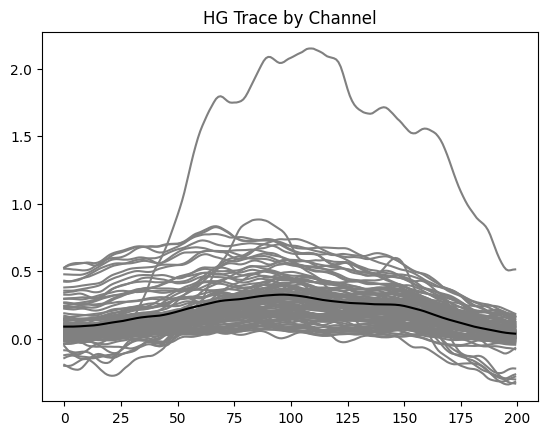

In [3]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1D CNN Bidirectional LSTM seq2seq

In [4]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [5]:
# parameters
n_output = 10

In [6]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [7]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 200, 111) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [8]:
# imports
from seq2seq_models.rnn_models import lstm_1Dcnn_model


In [9]:
# parameters
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
n_filters = 100
filter_size = 10
n_units = 800
reg_lambda = 1e-6
bidir = False

In [10]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [11]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 111)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 100)      111100      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    5486410     ['conv1d[0][0]',                 
 nal)                                                             'input_2[0][0]

Train Model

In [12]:
# imports
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [13]:
# parameters
num_folds = 10
batch_size = 150
epochs = 100
learning_rate = 1e-3

In [14]:
train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
models, histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y, num_folds=num_folds, batch_size=batch_size, epochs=epochs)

========== Fold 1 ==========
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 2.3997 - accuracy: 0.0025 - val_loss: 2.2074 - val_accuracy: 0.2000
Epoch 2/100
1/1 [==============================] - 0s 316ms/step - loss: 2.1856 - accuracy: 0.1841 - val_loss: 2.3101 - val_accuracy: 0.1333
Epoch 3/100
1/1 [==============================] - 0s 297ms/step - loss: 2.1830 - accuracy: 0.1692 - val_loss: 2.1887 - val_accuracy: 0.1111
Epoch 4/100
1/1 [==============================] - 0s 310ms/step - loss: 2.0993 - accuracy: 0.2239 - val_loss: 2.1400 - val_accuracy: 0.2889
Epoch 5/100
1/1 [==============================] - 0s 314ms/step - loss: 2.0680 - accuracy: 0.2512 - val_loss: 2.1874 - val_accuracy: 0.1111
Epoch 6/100
1/1 [==============================] - 0s 296ms/step - loss: 2.0290 - accuracy: 0.2662 - val_loss: 2.1840 - val_accuracy: 0.2222
Epoch 7/100
1/1 [==============================] - 0s 304ms/step - loss: 1.9927 - accuracy: 0.2289 - val_loss: 2.1525 - val_accu

In [16]:
len(histories['loss'][0])

100

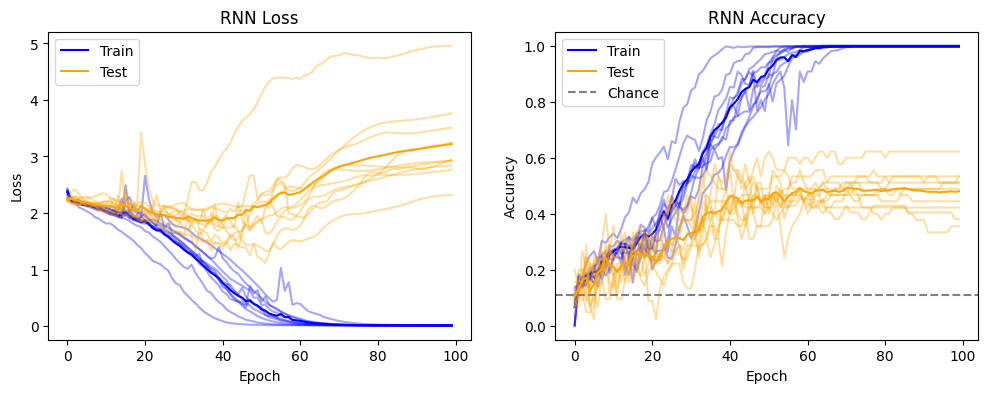

In [19]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

In [ ]:
import seaborn as sns

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()